In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd

DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/data'
VAL_TO_IDX_DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Server/data'

MODEL_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/model'

In [2]:
problem_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_problem.csv'))
problem_df['problem_id'] = problem_df['problem_id'].astype(str)

In [28]:
# problem_association_seq 제작

import re

problem_association_seq_list = set()
problem_id_list = problem_df['problem_id'].tolist()

problem_association_list = problem_df['problem_association'].tolist()
title_list = problem_df['title'].tolist()
for title, problem_association in zip(title_list, problem_association_list):
    problem_association = eval(problem_association)
    if problem_association:
        problem_association += [title]
        problem_association = sorted(list(set(problem_id_list) & set(re.findall(r'([0-9]+?)번', '#'.join(problem_association)))))
        problem_association_seq_list.add(tuple(problem_association))

problem_association_seq_list = list(map(list, problem_association_seq_list))

len(problem_association_seq_list)

23

In [33]:
# level로 seq 제작

problem_level_seq_list = []

group_df = problem_df.groupby('level')

for level, df in group_df:
    problem_level_seq_list.append(df['problem_id'].tolist())

len(problem_level_seq_list)

25

In [34]:
# tag로 seq 제작

problem_tag_seq_list = []

tag_list = []

def get_preprocessing_tags(tags):
    global tag_list
    tags = eval(tags)
    if tags:
        tags = [tag['key'] for tag in tags]
        tag_list += tags
    return tags

problem_df['preprocessing_tags'] = problem_df['problem_tags'].apply(lambda x : get_preprocessing_tags(x))
tag_list = list(set(tag_list))
problem_num_list = problem_df['problem_id'].tolist()

tag_df = pd.DataFrame(data = np.zeros((len(problem_num_list), len(tag_list))), columns = tag_list, index = problem_num_list)

for df in problem_df.iloc:
    tag_df.loc[df['problem_id'], df['preprocessing_tags']] = 1

for tag in tag_list:
    problem_tag_seq = tag_df[tag_df[tag] == 1].index.tolist()
    problem_tag_seq_list.append(problem_tag_seq)
    
len(problem_tag_seq_list)

176

In [35]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed

        self.loss_to_be_subed = loss

        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save(os.path.join(MODEL_PATH, 'clean-Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128.model'))
            print(f'Loss after epoch {self.epoch}: {loss_now}')
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

sentences = problem_association_seq_list + problem_level_seq_list + problem_tag_seq_list

model = Word2Vec(
                sentences = sentences,
                seed = 22,
                epochs = 300,
                min_count = 1,
                vector_size = 128,
                sg = 0,
                negative = 10,
                window = 987654321,
                compute_loss = True, 
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

Loss after epoch 1: 55665.00390625
Model 저장
Loss after epoch 2: 36641.78515625
Model 저장
Loss after epoch 3: 35483.2421875
Model 저장
Loss after epoch 4: 34924.8125
Model 저장
Loss after epoch 5: 19941.71875
Model 저장
Loss after epoch 12: 15958.75
Model 저장
Loss after epoch 13: 15295.0625
Model 저장
Loss after epoch 14: 14843.25
Model 저장
Loss after epoch 20: 13073.5
Model 저장
Loss after epoch 21: 12828.1875
Model 저장
Loss after epoch 24: 12328.3125
Model 저장
Loss after epoch 26: 12048.0625
Model 저장
Loss after epoch 33: 11213.875
Model 저장
Loss after epoch 35: 11188.5625
Model 저장
Loss after epoch 36: 10946.625
Model 저장
Loss after epoch 40: 10668.625
Model 저장
Loss after epoch 48: 10395.1875
Model 저장
Loss after epoch 49: 10280.125
Model 저장
Loss after epoch 58: 9892.5
Model 저장
Loss after epoch 62: 9891.375
Model 저장
Loss after epoch 69: 9824.0
Model 저장
Loss after epoch 70: 9693.75
Model 저장
Loss after epoch 73: 9659.125
Model 저장
Loss after epoch 74: 9657.5
Model 저장
Loss after epoch 77: 9656.25
Model 저장
L

In [3]:
from gensim.models import Word2Vec

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_problem_id_to_idx.json'), 'r', encoding = 'utf-8') as f:
    problem_id2idx = json.load(f)

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_idx_to_problem_id.json'), 'r', encoding = 'utf-8') as f:
    idx2problem_id = json.load(f)

item2vec = Word2Vec.load(os.path.join(MODEL_PATH, 'clean-Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128.model'))

vectors = []
for idx in range(len(problem_id2idx)):
    vectors.append(item2vec.wv[idx2problem_id[str(idx)]])
vectors = np.array(vectors)

In [4]:
with open(os.path.join(MODEL_PATH, 'clean-Word2Vec-CBOW-problem_association_seq-problem_level_seq-problem_tag_seq-vs128-vector.pickle'), 'wb') as file:
    pickle.dump(vectors, file, protocol = 4)

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(vectors)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


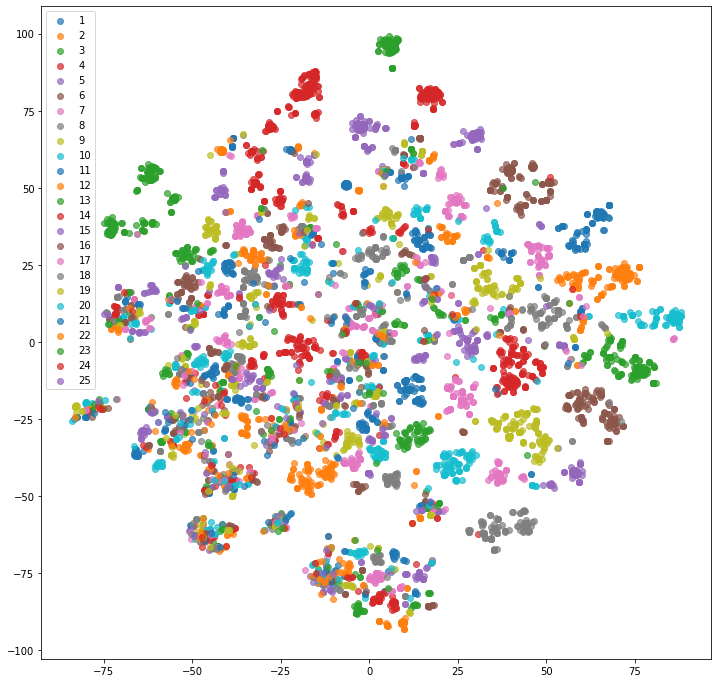

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))

problem_df['problem_id2idx'] = problem_df['problem_id'].apply(lambda x : int(problem_id2idx[x]))

for level in sorted(problem_df['level'].unique()):
    idx = problem_df[problem_df['level'] == level]['problem_id2idx'].tolist()
    plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level}') 

plt.legend()
plt.show()

In [25]:
tsne_vectors_df = pd.DataFrame(data = tsne_vectors, columns = ['x', 'y'])

In [34]:
idx = tsne_vectors_df[((-60 <= tsne_vectors_df['x']) & (tsne_vectors_df['x'] <= -35)) & ((-100 <= tsne_vectors_df['y']) & (tsne_vectors_df['y'] <= -50))].index.tolist()